# Cretaceous Cordilleran Validation

In this section, I use isopachs from a 1995 USGS report<sup>1</sup>. There are six series of isopachs through the Late Cretaceous:

- Cenomanian: 98.5-93.5 Ma (~5 My)
- Turonian: 93.5-88.5 Ma (~5 My)
- Coniacian-Santonian: 88.5-83.5 Ma (~5 My)
- Campanian I: 83.5-79 Ma (~4.5 My)
- Campanian II: 79-72 Ma (~7 My)
- Maastrichtian: 72-65.5 Ma (~6.5 My)

<sup>1</sup>Robinson Roberts, L.N. & Kirschbaum, M.A. (1995) Paleogeography of the late Cretaceous of the western interior of middle North America - coal distribution and sediment accumulation. US Geol. Surv. Prof. Pap., Vol. 1561. doi:10.3133/pp1561

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import notebook
import geopandas as gpd
from helper import *

import rasterio
from rasterstats import zonal_stats
from rasterio.mask import mask
from shapely.geometry import mapping
import glob

In [3]:
columns = load_shapefile('data/columns.gpkg', 'col_id', project_id=1)
units = load_shapefile('data/units.gpkg', 'unit_id', project_id=1)
units_seds = load_shapefile('data/units_seds.gpkg', 'unit_id', project_id=1)

In [4]:
thick_rast = glob.glob('gis/isopachs/[0-6]*thick_wgs.tif')
columns_cord = gpd.read_file('gis/USGS_cordilleran_columns_wgs_4.shp')

## Macrostrat column-wise USGS isopach thickness distributions

It would be nice to check what the distributions of accumulated sediment thicknesses from the interpolated, digitized USGS isopachs look like in each Macrostrat column.

  0%|          | 0/123 [00:00<?, ?it/s]

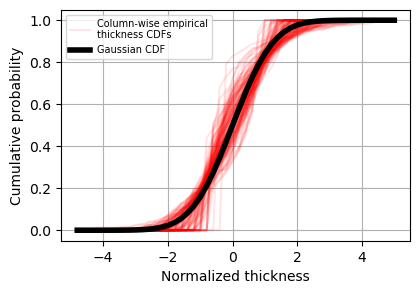

In [9]:
geoms = columns_cord.geometry.values

fig = plt.figure(figsize=(4.5, 3))

# plot normalized histograms for thicknesses in each column
out_images = []
Ds = []
ps = []
for geom in notebook.tqdm(geoms):
    geom = [mapping(geom)]
    with rasterio.open(thick_rast[0]) as src:
        out_image, out_transform = mask(src, geom, crop=True)
    out_image = out_image.reshape(-1)
    out_image[out_image < 0] = np.nan
    out_image = (out_image - np.nanmean(out_image))/np.nanstd(out_image)
    out_images.append(out_image)
    if not len(out_image[np.logical_not(np.isnan(out_image))]) == 0:
        ks = stats.kstest(out_image[np.logical_not(np.isnan(out_image))], 'norm')
        Ds.append(ks[0])
        ps.append(ks[1])
    counts, bin_edges = np.histogram(out_image, bins=np.linspace(-5, 5, 51), density=True)
    cdf = np.cumsum(counts)/5
    l1 = plt.plot(bin_edges[1:], cdf, color='r', alpha=0.1)

# convert to arrays
ps = np.asarray(ps)
Ds = np.asarray(Ds)

# plot
l2 = plt.plot(bin_edges[1:], stats.norm.cdf(bin_edges[1:], 0, 1), linewidth=4, color='k')
plt.xlabel('Normalized thickness')
plt.ylabel('Cumulative probability')
plt.legend((l1[0], l2[0]), ('Column-wise empirical\nthickness CDFs', 'Gaussian CDF'), fontsize=7)
plt.grid()
plt.autoscale(axis='both')
plt.savefig('figures/cordilleran_validation/usgs_columnwise_cdfs.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [46]:
thres = 0.05
ps_thres = np.sum(ps > thres)/len(ps)
print('KS-test: %1.0f%% of data consistent with normal distribution at %d%% confidence level' % (100*ps_thres, 100*thres))

KS-test: 50% of data consistent with normal distribution at 5% confidence level


So clearly a normal distribution is not excellent for most of the data, but it's not terrible either and convenience takes precedence for us here. So we'll proceed with normal parameterizations for the digitized sediment thickness data in the Macrostrat columns.

## column-wise thickness statistics

First let's get the thickness rasters created from the digitized contours.

In [ ]:
ages = ['Cenomanian', 'Turonian', 'Coniancian-Santonian', 'Campanian I', 'Campanian II', 'Maastrichtian']
usgs_obs = ['mean', 'std', 'weight']
macrostrat_pred = ['min_thick', 'max_thick', 'med_thick', 'std', 'weight']

usgs_cols = pd.MultiIndex.from_product([ages + ['total'], usgs_obs], names=['ages', 'obs'])
usgs = pd.DataFrame(columns=usgs_cols, index=columns_cord['col_id'])
ms_cols = pd.MultiIndex.from_product([ages + ['total'], macrostrat_pred], names=['ages', 'pred'])
ms = pd.DataFrame(columns=ms_cols, index=columns_cord['col_id'], dtype=float)

# time bounds for ages reported in USGS report
age_bounds_usgs = np.array([[98.5, 93.5],
                           [93.5, 88.5],
                           [88.5, 83.5], 
                           [83.5, 79],
                           [79, 72],
                           [72, 65.5]])

# update time bounds (GSA timescale, 2013)
age_bounds_gsa = np.array([[100, 93.9],
                           [93.9, 89.8],
                           [89.8, 83.6], 
                           [83.6, 79.1],
                           [79.1, 72.1],
                           [72.1, 66]])

# age durations
age_durations_gsa = np.abs(np.diff(age_bounds_gsa, axis=1))
tot_dur_gsa = np.ptp(age_bounds_gsa)

for ii, rast in notebook.tqdm(enumerate(thick_rast)):
    # gather data from USGS rasters into macrostrat columns
    col_stats = zonal_stats('gis/USGS_cordilleran_columns_wgs_4.shp', rast, stats=['mean', 'std'])
    means = np.asarray([x['mean'] for x in col_stats], dtype=float)*100
    stds = np.asarray([x['std'] for x in col_stats], dtype=float)*100
    usgs[ages[ii]] = np.column_stack([means, stds, np.zeros(len(means))])
    # construct macrostrat estimates for same time periods
    cord_thicks = seds_by_column_and_age_range(units_seds, columns, age_bounds_gsa[ii,0], age_bounds_gsa[ii,1])
    # lets only worry about thicknesses in the cordilleran foreland
    cord_thicks = cord_thicks.loc[columns_cord['col_id']]
    cord_thicks['med_thick'] = (cord_thicks['max_thick']-cord_thicks['min_thick'])/2 + cord_thicks['min_thick']
    ms.loc[ms.index, (ages[ii],['min_thick', 'max_thick', 'med_thick'])] = cord_thicks[['min_thick', 'max_thick', 'med_thick']].values

Now I will also make assumptions about the statistical interpretation of the minimum and maximum thickness estimates provided by Macrostrat, since to leverage the MSWD computation of York (1969), we must cast all observations into a Gaussian framework. I proceed for the moment by assuming that the minimum and maximum thicknesses correspond to the 2.5 and 97.5 percentiles for a Gaussian distribution of thicknesses within a Macrostrat column and age range. The following function computes the corresponding mean and standard deviation. Obviously this assumption violates physical reality because it permits negative sediment thicknesses, but for now we will just have to deal with this.

In [28]:
# this function computes the mean and standard deviation for a Gaussian for which the cdf is known at two points
def norm_from_ci(x_min, x_max, p_min, p_max):
    sig = (x_max-x_min)/(np.sqrt(2)*(sp.special.erfinv(2*p_max-1)-sp.special.erfinv(2*p_min-1)))
    mu = x_min - np.sqrt(2)*sig*sp.special.erfinv(2*p_min-1)
    return mu, sig

Having made this assumption, I will also specify that Macrostrat columns with zero sediment thickness will have zero weight when computing the MSWD, simply because it is not obvious how to assign uncertainty for these columns, and so we just assume that they have infinite uncertainty (hence, weights are zero). All other columns will have weights computed as $\frac{1}{\sigma^2}$.

In [29]:
# set up weights
for age in ages:
    cur_mu, cur_std = norm_from_ci(ms[age]['max_thick'], 
                                   ms[age]['min_thick'],
                                   0.975, 0.025)
    cur_std[cur_std==0] = np.inf
    idx = (ms[age, 'max_thick'] == 0) & (ms[age, 'max_thick'] == ms[age, 'min_thick'])
    ms[age, 'std'] = cur_std
    ms[age, 'weight'] = 1/(cur_std**2)
    usgs[age, 'weight'] = 1/usgs[age, 'std']**2

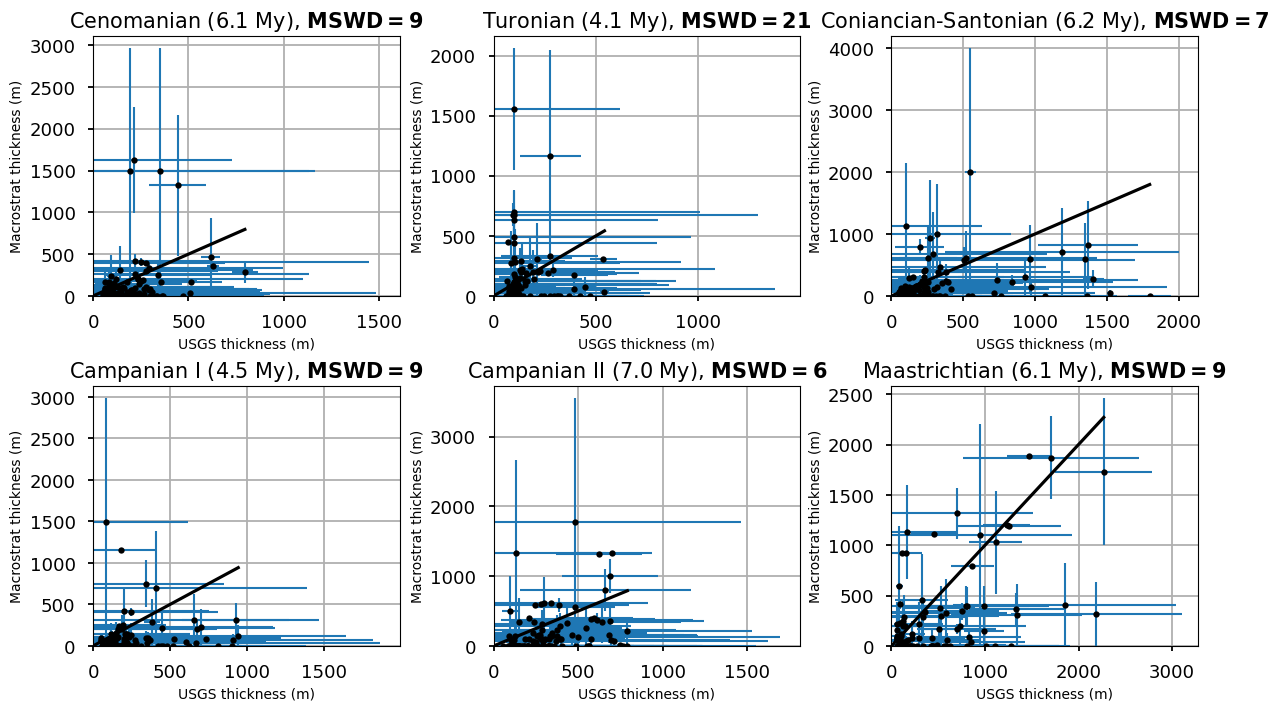

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(12,7), constrained_layout=True)

mswds = []
for ii in range(6):
    idx = usgs[ages[ii], 'mean'] > 50
    err = np.abs(np.row_stack((ms[ages[ii], 'min_thick'].values, 
                               ms[ages[ii], 'max_thick'].values))-ms[ages[ii], 'med_thick'].values)
    
    # compute MSWD before plotting
    idx2 = idx & (ms[ages[ii], 'std'] != np.inf) & (np.logical_not(np.isnan(usgs[ages[ii], 'std'])))
    # compute correlation coefficient betweeen errors
    r = np.corrcoef(usgs.loc[idx2][ages[ii], 'std'], ms.loc[idx2][ages[ii], 'std'])[0,1]
    mswds.append(yorkfit(usgs.loc[idx2][ages[ii], 'mean'],
                   ms.loc[idx2][ages[ii], 'med_thick'], 
                   usgs.loc[idx2][ages[ii], 'weight'],
                   ms.loc[idx2][ages[ii], 'weight'],
                   r)[4])
    
    idx_ax = np.unravel_index(ii, ax.shape)
    ax[idx_ax].errorbar(usgs.loc[idx][ages[ii], 'mean'],
                 ms.loc[idx][ages[ii], 'med_thick'], 
                 xerr=2*stds[idx], 
                 yerr=err[:, idx], fmt='.', markerfacecolor='k', elinewidth=1.5)
    ax[idx_ax].plot([0, np.max(usgs.loc[idx][ages[ii], 'mean'])], 
                    [0, np.max(usgs.loc[idx][ages[ii], 'mean'])], 'k-')
    ax[idx_ax].set_title('%s (%1.1f My), $\\bf{MSWD=%1.0f}$' % (ages[ii], 
                                                                 age_durations_gsa[ii][0],
                                                                 mswds[ii]), fontsize=15)
    ax[idx_ax].set_xlabel('USGS thickness (m)')
    ax[idx_ax].set_ylabel('Macrostrat thickness (m)')
    ax[idx_ax].set_xlim([0, ax[idx_ax].get_xlim()[1]])
    ax[idx_ax].set_ylim([0, ax[idx_ax].get_ylim()[1]])
    ax[idx_ax].grid()

    # plt.errorbar(means[idx], thicks.iloc[idx][])
plt.savefig('figures/cordilleran_validation/by_age.pdf', format='pdf', bbox_inches='tight')

Clearly the column-wise thicknesses do not correspond well between the USGS isopachs and the range of conceivable Macrostrat thicknesses. In none of the cases are the residuals from a linear model consistent at any reasonable probability with the observed thicknesses (despite one deceptively low MSWD for the Campanian II interval).  

However, it is possible that averaged over longer timescales, the Macrostrat data will more closely track more finely resolved sedimentation histories. In the next few code blocks, I total sedimentation over the entire Late Cretaceous interval from the Cenomanian to the Maastrichtian to see how the USGS and Macrostrat records compare.

In [ ]:
# total thickness
col_stats = zonal_stats('gis/USGS_cordilleran_columns_wgs_4.shp', 'gis/isopachs/total_km_wgs.tif', stats=['mean', 'std'])
tot_means = np.asarray([x['mean'] for x in col_stats], dtype=float)*1000
tot_stds = np.asarray([x['std'] for x in col_stats], dtype=float)*1000
usgs['total', 'mean'] = tot_means
usgs['total', 'std'] = tot_stds
usgs['total', 'weight'] = 1/tot_stds**2

# construct macrostrat estimates for same time periods
total_thicks = seds_by_column_and_age_range(units_seds, columns, 100, 66)
total_thicks = total_thicks.loc[columns_cord['col_id']]
total_thicks['med_thick'] = (total_thicks['max_thick']-total_thicks['min_thick'])/2 + total_thicks['min_thick']
ms.loc[ms.index, ('total',['min_thick', 'max_thick', 'med_thick'])] = total_thicks[['min_thick', 'max_thick', 'med_thick']].values
# ms['total'] = total_thicks[['min_thick', 'max_thick', 'med_thick']]

cur_mu, cur_std = np.abs(norm_from_ci(ms['total', 'max_thick'], 
                               ms['total', 'min_thick'],
                               0.975, 0.025))
ms['total', 'std'] = cur_std
ms['total', 'weight'] = 1/(cur_std**2)

err = np.abs(np.row_stack((total_thicks['min_thick'].values, 
                           total_thicks['max_thick'].values))-total_thicks['med_thick'].values)

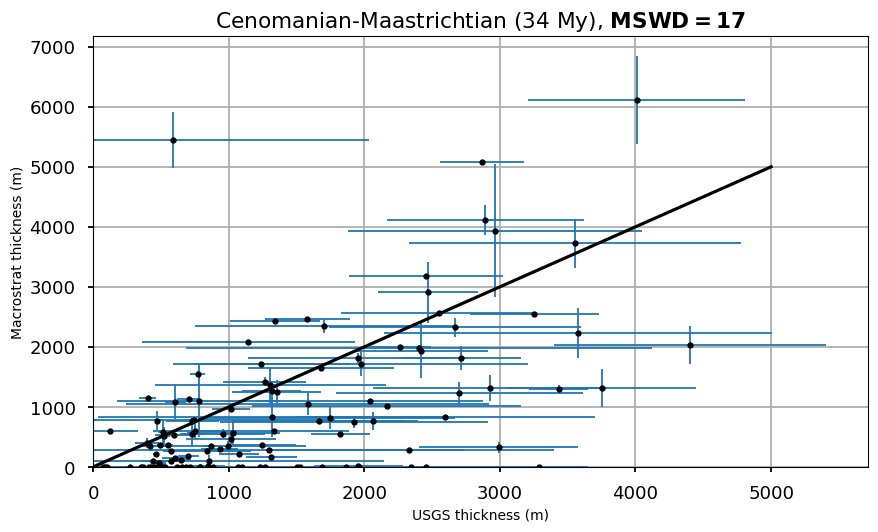

In [36]:
idx = tot_means > 50

# compute mswd over all data
idx2 = idx & (ms['total', 'weight'] != np.inf) & (np.logical_not(np.isnan(usgs['total', 'std'])))
# compute correlation coefficient betweeen errors
r = np.corrcoef(usgs.loc[idx2]['total', 'std'], ms.loc[idx2]['total', 'std'])[0,1]
mswd = yorkfit(usgs.loc[idx2]['total', 'mean'],
               ms.loc[idx2]['total', 'med_thick'], 
               usgs.loc[idx2]['total', 'weight'],
               ms.loc[idx2]['total', 'weight'],
               r)[4]

plt.figure(figsize=(10, 5.6))
plt.errorbar(usgs.loc[idx]['total', 'mean'],
             ms.loc[idx]['total', 'med_thick'], 
             xerr=2*usgs.loc[idx]['total', 'std'], 
             yerr=err[:, idx], fmt='.', markerfacecolor='k', elinewidth=1.3)

plt.plot([0, 5000], [0, 5000], 'k-')
plt.xlabel('USGS thickness (m)')
plt.ylabel('Macrostrat thickness (m)')
plt.title('Cenomanian-Maastrichtian (%1.0f My), $\\bf{MSWD=%1.0f}$' % (tot_dur_gsa,
                                                                 mswd) )
plt.xlim([0, plt.gca().get_xlim()[1]])
plt.ylim([0, plt.gca().get_ylim()[1]])
plt.grid()
plt.savefig('figures/cordilleran_validation/full_thickness.pdf', format='pdf', bbox_inches='tight')
plt.show()